In [1]:
from pickle import dump,load
#for cleaning
import string
#for pretrained cnn model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Model
#for extracting feautres from all given images
from os import listdir
from time import time
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
#for main model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Text Preprocessing

In [4]:
def load_doc(filename):
    with open(filename) as file:
        text = file.read()
        return text

filename = 'C:/Users/97798/Desktop/ImageCaption/flick8k/Flickr_TextData/Flickr8k.token.txt'
doc = load_doc(filename)


print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [5]:
def image_to_captions_mapping(captions):  
    # Dictionary to keep the mapping of photo identifiers to captions
    captions_mapping = {}
    # Iterating through each line of the captions
    for i in captions.split('\n'):# i = line 
        # Splitting the lines by white space
        words = i.split()  
        if len(i) < 2:
            continue 
        # Retaining only the name of the image and removing the extension from it
        img_id = words[0].split('.')[0]
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        img_caption = ' '.join(words[1:])  
        if img_id not in captions_mapping:
            captions_mapping[img_id] = [img_caption]     
        # Now storing the descriptions in the mapping
        captions_mapping[img_id].append(img_caption)
    return captions_mapping

captions = image_to_captions_mapping(doc)
print('Loaded: %d ' % len(captions))
#list index out of range error due to if len(i)<2 is removed
#captions

Loaded: 8092 


In [4]:
list(captions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [5]:
captions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
clean_descriptions(captions)

In [7]:
captions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large pa

In [8]:
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# Summarizing the vocabulary

vocabulary = to_vocabulary(captions)

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [10]:
# # # save captions to file, one per line
# def save_captions(captions, filename):
#     lines = list()
#     for key, cap_list in captions.items():
#         for cap in cap_list:
#             lines.append(key + ' ' + cap)
#     data = '\n'.join(lines)
#     file = open(filename, 'w')
#     file.write(data)
#     file.close()

# save_captions(captions, 'captions.txt')

# Loading training set


In [9]:
def load_set(path):   
    file = load_doc(path)    
    # Creating a list for storing the identifiers
    images = list()    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue       
        # Image name contains the extension as well but we need just the name
        identifier = line.split('.')[0]      
        # Adding it to the list of photos
        images.append(identifier)     
        
    # Returning the set of photos created
    return set(images)

path = 'C:/Users/97798/Desktop/ImageCaption/flick8k/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(path)
print('The length of Dataset: ',len(train))
#train

The length of Dataset:  6000


In [11]:
def load_cleaned_captions(path, images):
    file = load_doc(path)
    captions = {}         
    for i in file.split('\n'): #i =line, \n = new line
        # splitting the line at white spaces
        words = i.split()
        img_id, img_caption = words[0],words[1:]
        if img_id in images:
            #creating list of captions if needed
            if img_id not in captions:
                captions[img_id] = list()
                cap = 'startofseq ' + ' '.join(img_caption) + ' endofseq'
            captions[img_id].append(cap)           
    return captions

train_captions = load_cleaned_captions('captions.txt', train)
#print('The number of captions for train images :', len(train_captions))
len(train_captions)

6000

In [12]:
train_captions

{'1000268201_693b08cb0e': ['startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq child in pink dress is climbing up set of stairs in an entry way endofseq',
  'startofseq child in pink dress is climbing up set of stairs in an entry way endofseq'],
 '1001773457_577c3a7d70': ['startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and spotted dog are fighting endofseq',
  'startofseq black dog and spotted dog are fighting endofseq'],
 '1002674143_1b742ab4b8'

In [15]:
# pretrained_model = InceptionV3(weights='imagenet')
# #removing predictions (Dense) layer from model
# model_new = Model(inputs = pretrained_model.input,outputs = pretrained_model.layers[-2].output)
# model_new.summary()

In [16]:
# image_path = 'C:/Users/97798/Desktop/ImageCaption/flick8k/Images'
# features = {}
# start = time()
# for i in listdir(image_path):
#     # Defining the path of the image 
#     filename = image_path + '/' + i
#     # Loading an image and resizing it into 299*299
#     image = load_img(filename, target_size=(299, 299))
#     # convert the image pixels to a numpy array
#     image = img_to_array(image)
#     # reshape data for the model
#     image = image.reshape(1,299,299,3)#(1,299,299,3) mean 1 image in 299 X 299 with 3 channel.
#     # process reshape data of the image for the incpetionv3 model
#     image = preprocess_input(image)
#     # getting image features
#     #By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.verbose=0 will show you nothing (silent) and verbose=1 will show you an animated progress bar.
#     feature = model_new.predict(image)
#     # get image id
#     image_id = i.split('.')[0]#it just grap the image name
#     # keeping into features dictionary with image id
#     features[image_id] = feature
#     print('>%s' % i)
# print("Time taken for encoding images {} seconds ".format(time()-start))    
    


In [16]:
# print('Extracted Features: %d' % len(features))

In [17]:
# dump(features, open('extracted_features.pkl', 'wb'))

In [11]:
def load_generated_features(filename, photos):
    #this will load the entire features
    all_features = load(open(filename, 'rb'))
    #we are interested in loading the features of the required photos only
    features = {i: all_features[i] for i in photos} 
    return features

train_features = load_generated_features('extracted_features.pkl',train)
print('Extracted features photos for train=%d' % len(train_features))
#yesma kina error aayo vanda chai .... mathi sabai images ko features extract navayera rayexa... captions haru imagesko naam ma map hunxa

Extracted features photos for train=6000


In [60]:
# train_features

# Caption Tokenization & Numeric Mapping 

In [12]:
# Create a list of all the training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)  
print(len(all_train_captions))



36000


In [13]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 3847 -> 1972


In [65]:
# count_words = {}
# for k in all_train_captions:
#     for word in k.split():
#         if word not in count_words:
#             count_words[word] = 0
#         else:
#             count_words[word] += 1

In [66]:
# count_words

In [14]:
ix_word = {}
word_ix = {}

ix = 1
for w in vocab:
    word_ix[w] = ix
    ix_word[ix] = w
    ix += 1

In [15]:
print("word_index type: ", type(word_ix))
print("First few (key, value) paris of word_index:") 
for i, (k, v) in enumerate(word_ix.items()):
    print(k, v)
    if i>2:
        break
print("")
print("index_word type: ", type(ix_word))
print("First few (key, value) pairs of index_word:") 
for i, (k, v) in enumerate(ix_word.items()):
    print(k, v)
    if i>2:
        break

word_index type:  <class 'dict'>
First few (key, value) paris of word_index:
startofseq 1
child 2
in 3
pink 4

index_word type:  <class 'dict'>
First few (key, value) pairs of index_word:
1 startofseq
2 child
3 in
4 pink


In [16]:
vocab_size = len(ix_word) + 1 # one for appended 0's
print('The size of Vocabulary is ',vocab_size)


The size of Vocabulary is  1973


In [17]:
#convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

MAX_LEN = 0
lines = to_lines(train_captions)
MAX_LEN = max(len(d.split()) for d in lines)
print('MAXIMUM LENGTH OF CAPTIONS: ',MAX_LEN)

MAXIMUM LENGTH OF CAPTIONS:  30


 X1	     X2(sequence)	                          Y (word)
 
photo	Startofseq,	                                 boy

photo	Startofseq,boy,	                           dancing

photo	Startofseq,boy,dancing,	                      the

photo	Startofseq,boy,dancing,the,	                 green

photo	Startofseq, boy,dancing,the,green,	         floor

photo	Startofseq, boy,dancing,the,green,floor,	endofseq


In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array

def create_sequences(word_ix, max_len, captions, images, size_of_vocab):
    X1 = list()
    X2 = list()
    y = list() 
    # moving through each image identifier
    for key, desc_list in captions.items():
        # moving through each description for the image
        for desc in desc_list:
            # encode the sequence
            sequence = [word_ix[word] for word in desc.split(' ') if word in word_ix]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(sequence)):
                # split into input and output pair
                in_seq = sequence[:i]
                out_seq = sequence[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=size_of_vocab)[0]
                # store
                X1.append(images[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [19]:
X1train, X2train, ytrain = create_sequences(word_ix, MAX_LEN, train_captions, train_features, vocab_size)


In [20]:
X1train.shape,X2train.shape,ytrain.shape

((356598, 2048), (356598, 30), (356598, 1973))

In [21]:
filename = 'C:/Users/97798/Desktop/ImageCaption/flick8k/Flickr_TextData/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_cleaned_captions('captions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_generated_features('extracted_features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(word_ix, MAX_LEN, test_descriptions, test_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [22]:
import os
import numpy as np
# Load Glove vectors
glove_dir = 'C:/Users/97798/Desktop/Practise/New folder/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_ix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(1973, 200)

# Model 1

In [24]:

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(MAX_LEN,))
#mask_zero=true to ignore padded value
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.load_weights("../input/model_weights.h5")

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      394600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [25]:
model.fit([X1train, X2train], ytrain, epochs = 25, batch_size = 256,validation_data=([X1test, X2test], ytest))


Epoch 1/25
1393/1393 [==============================] - 590s 423ms/step - loss: 4.0434 - accuracy: 0.2662 - val_loss: 3.7541 - val_accuracy: 0.3008
Epoch 2/25
1393/1393 [==============================] - 631s 453ms/step - loss: 3.3943 - accuracy: 0.3222 - val_loss: 3.7328 - val_accuracy: 0.3091
Epoch 3/25
1393/1393 [==============================] - 632s 454ms/step - loss: 3.1824 - accuracy: 0.3435 - val_loss: 3.7925 - val_accuracy: 0.3156
Epoch 4/25
1393/1393 [==============================] - 590s 424ms/step - loss: 3.0530 - accuracy: 0.3575 - val_loss: 3.8505 - val_accuracy: 0.3124
Epoch 5/25
1393/1393 [==============================] - 613s 440ms/step - loss: 2.9635 - accuracy: 0.3702 - val_loss: 3.9770 - val_accuracy: 0.3098
Epoch 6/25
1393/1393 [==============================] - 616s 442ms/step - loss: 2.9048 - accuracy: 0.3776 - val_loss: 4.0184 - val_accuracy: 0.3010
Epoch 7/25
1393/1393 [==============================] - 624s 448ms/step - loss: 2.8548 - accuracy: 0.3858 - val_

In [52]:
for i in range(30):
    model.fit([X1train, X2train], ytrain, epochs = 1, batch_size = 256,validation_data=([X1test, X2test], ytest))
    if(i%2 == 0):
        model.save_weights("image-caption-weights" + str(i) + ".h5")


Epoch 1/25
1393/1393 [==============================] - 506s 363ms/step - loss: 2.7654 - accuracy: 0.4274
Epoch 2/25
1393/1393 [==============================] - 511s 367ms/step - loss: 2.7641 - accuracy: 0.4296
Epoch 3/25
1393/1393 [==============================] - 520s 373ms/step - loss: 2.7648 - accuracy: 0.4304
Epoch 4/25
1393/1393 [==============================] - 512s 367ms/step - loss: 2.7722 - accuracy: 0.4307
Epoch 5/25
1393/1393 [==============================] - 516s 370ms/step - loss: 2.7798 - accuracy: 0.4311
Epoch 6/25
1393/1393 [==============================] - 519s 373ms/step - loss: 2.7825 - accuracy: 0.4320
Epoch 7/25
1393/1393 [==============================] - 517s 371ms/step - loss: 2.7880 - accuracy: 0.4323
Epoch 8/25
1393/1393 [==============================] - 515s 370ms/step - loss: 2.7944 - accuracy: 0.4314
Epoch 9/25
1393/1393 [==============================] - 520s 374ms/step - loss: 2.7991 - accuracy: 0.4328
Epoch 10/25
1393/1393 [=======================

In [53]:
model.save('model-rms.h5')
model.save_weights('model_weights-rms.h5')


# Model 2

In [37]:
from keras.regularizers import l2

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model_1 = Model(inputs=[inputs1, inputs2], outputs=outputs)

model_1.layers[2].set_weights([embedding_matrix])
model_1.layers[2].trainable = False
model_1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# summarize model
print(model_1.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 200)      394600      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_7[0][0]                    
_______________________________________________________________________________________

In [51]:
from keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3)

In [60]:
data_1 = model_1.fit([X1train, X2train], ytrain, epochs=25, verbose=1, callbacks=[es], validation_data=([X1test, X2test], ytest))

Epoch 1/25
11144/11144 [==============================] - 968s 87ms/step - loss: 3.6629 - accuracy: 0.3029 - val_loss: 4.6665 - val_accuracy: 0.2815
Epoch 2/25
11144/11144 [==============================] - 1167s 105ms/step - loss: 3.4872 - accuracy: 0.3221 - val_loss: 4.9835 - val_accuracy: 0.2882
Epoch 3/25
11144/11144 [==============================] - 1111s 100ms/step - loss: 3.4067 - accuracy: 0.3347 - val_loss: 5.1003 - val_accuracy: 0.2832
Epoch 4/25
11144/11144 [==============================] - 1110s 100ms/step - loss: 3.3540 - accuracy: 0.3426 - val_loss: 5.1071 - val_accuracy: 0.2730


In [54]:
model_1.save('model-2.h5')
model_1.save_weights('model_weights-2.h5')


# Model 3

In [17]:
# from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
# from keras.models import Sequential, Model
# from keras.utils import to_categorical
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Embedding
# from keras.layers import Dropout
# from keras.layers.merge import add

In [18]:
# embedding_size = 200

# image_model = Sequential()
# image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
# image_model.add(RepeatVector(MAX_LEN))


# language_model = Sequential()
# language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=MAX_LEN))
# language_model.add(LSTM(256, return_sequences=True))
# language_model.add(TimeDistributed(Dense(embedding_size)))

# conca = Concatenate()([image_model.output, language_model.output])
# x = LSTM(128, return_sequences=True)(conca)
# x = LSTM(512, return_sequences=False)(x)
# x = Dense(vocab_size)(x)
# out = Activation('softmax')(x)

# model_2 = Model(inputs=[image_model.input, language_model.input], outputs = out)


# model_2.layers[2].set_weights([embedding_matrix])
# model_2.layers[2].trainable = False

# # model.load_weights("../input/model_weights.h5")
# model_2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model_2.summary()

In [59]:
data_2 = model_2.fit([X1train, X2train], ytrain, epochs=30, verbose=1, callbacks=[es], validation_data=([X1test, X2test], ytest))

Epoch 1/30
11144/11144 [==============================] - 5472s 491ms/step - loss: 4.1599 - accuracy: 0.2751 - val_loss: 4.1740 - val_accuracy: 0.2869
Epoch 2/30
11144/11144 [==============================] - 5314s 477ms/step - loss: 3.8724 - accuracy: 0.3411 - val_loss: 4.6605 - val_accuracy: 0.2838
Epoch 3/30
11144/11144 [==============================] - 5268s 473ms/step - loss: 3.7924 - accuracy: 0.3691 - val_loss: 5.0138 - val_accuracy: 0.2592
Epoch 4/30
11144/11144 [==============================] - 5275s 473ms/step - loss: 3.5204 - accuracy: 0.4078 - val_loss: 5.6518 - val_accuracy: 0.2621


In [61]:
model_2.save('model-3.h5')
model_2.save_weights('model_weights-3.h5')


# MODEL 4

In [52]:

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(128, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(128)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(128, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model_4 = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.load_weights("../input/model_weights.h5")

model_4.layers[2].set_weights([embedding_matrix])
model_4.layers[2].trainable = False

model_4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_4.summary()


Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      394600      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_9[0][0]                    
______________________________________________________________________________________

In [ ]:
hist = model_4.fit([X1train, X2train], ytrain, 
                  epochs=30, verbose=1, 
                  batch_size=64,
                  validation_data=([X1test, X2test], ytest))

Epoch 1/30
5572/5572 [==============================] - 644s 116ms/step - loss: 4.0456 - accuracy: 0.2846 - val_loss: 4.0863 - val_accuracy: 0.2891
Epoch 2/30
5572/5572 [==============================] - 566s 102ms/step - loss: 4.0804 - accuracy: 0.2945 - val_loss: 4.1396 - val_accuracy: 0.2888
Epoch 3/30
5572/5572 [==============================] - 570s 102ms/step - loss: 4.0976 - accuracy: 0.2955 - val_loss: 4.1345 - val_accuracy: 0.2856
Epoch 4/30
3878/5572 [===================>..........] - ETA: 2:44 - loss: 4.0680 - accuracy: 0.2932

# Prediction

In [42]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from time import time
from os import listdir
from keras.models import load_model

from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as pyplt
from matplotlib import image

path='C:/Users/97798/Desktop/flick8k/Images/'
image_name=path+'2861932486_52befd8592.jpg'

def extraction_features(filename):
    # load the model
    model = InceptionV3()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(1,299,299,3)
    # prepare the image for the incpetionv3 model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image)
    return feature

extracted_image = extraction_features(image_name)

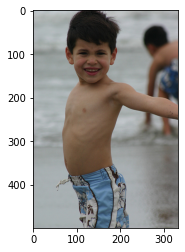

Caption : boy in swimsuit stands in the surf


In [41]:
import numpy as np
def greedySearch(model,photo,MAX_LEN):
    in_text = 'startofseq'
    for i in range(MAX_LEN):
        sequence = [word_ix[w] for w in in_text.split() if w in word_ix]
        sequence = pad_sequences([sequence], maxlen=MAX_LEN)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ix_word[yhat]
        in_text += ' ' + word
        if word == 'endofseq':
            break
    return in_text

MAX_LEN = 30
model = load_model('model-2.h5')
generated_caption = greedySearch(model,extracted_image,MAX_LEN)
#Removing startseq and endseq
stopwords = ['startofseq','endofseq']
newWords = generated_caption.split()

resultwords  = [word for word in newWords if word.lower() not in stopwords]
result = ' '.join(resultwords)

#plotting the image with generated caption
img = image.imread(image_name)
pyplt.imshow(img)
pyplt.show()
print('Caption : '+result)

In [39]:
captions['106490881_5a2dd9b7bd']


['A boy in his blue swim shorts at the beach .',
 'A boy in his blue swim shorts at the beach .',
 'A boy smiles for the camera at a beach .',
 'A young boy in swimming trunks is walking with his arms outstretched on the beach .',
 'Children playing on the beach .',
 'The boy is playing on the shore of an ocean .']

In [30]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['boy','in','swimsuit','stands','in','the','surf'],]
candidate = ['A','boy','in','his','blue','swim','shorts','at','the','beach']
blue_score = sentence_bleu(reference,candidate)
print(blue_score)

6.373704167435469e-155
